# INITIAL CODE EXECUTION IN GOOGLE COLAB AND PLOTTING REQUIRES GRAPHS

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2022-05-07 07:07:06--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.71, 18.160.200.126, 18.160.200.112, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.3’

hymenoptera_data.zi 100%[===================>]  45.10M   139MB/s    in 0.3s    

2022-05-07 07:07:06 (139 MB/s) - ‘hymenoptera_data.zip.3’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116

In [ ]:
data_dir='/content/hymenoptera_data'

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


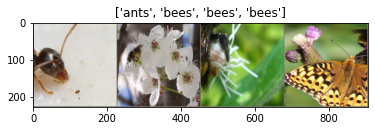

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    vallossplot = []
    accuracyplot = []
    x = list(range(0,num_epochs))
   
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                     

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

                best_model_wts = copy.deepcopy(model.state_dict())
                
        vallossplot.append(epoch_loss)
        accuracyplot.append(epoch_acc.item())
        

  
    
    plt.plot(x, vallossplot)
    plt.xlabel('epoch')
    plt.ylabel('Validation loss')
    plt.title('Validation loss graph')
    plt.show()



    plt.plot(x, accuracyplot)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy graph')
    plt.show()
           

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,x,epoch_loss,epoch_acc

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5463 Acc: 0.7090
val Loss: 0.2176 Acc: 0.9216
Epoch 1/24
----------
train Loss: 0.4293 Acc: 0.8279
val Loss: 0.3594 Acc: 0.8693
Epoch 2/24
----------
train Loss: 0.6452 Acc: 0.7295
val Loss: 0.8596 Acc: 0.7386
Epoch 3/24
----------
train Loss: 0.6880 Acc: 0.7131
val Loss: 0.2296 Acc: 0.9216
Epoch 4/24
----------
train Loss: 0.4820 Acc: 0.8115
val Loss: 0.2571 Acc: 0.9085
Epoch 5/24
----------
train Loss: 0.3664 Acc: 0.8484
val Loss: 0.7316 Acc: 0.7908
Epoch 6/24
----------
train Loss: 0.4745 Acc: 0.8197
val Loss: 0.2009 Acc: 0.9346
Epoch 7/24
----------
train Loss: 0.3538 Acc: 0.8484
val Loss: 0.2030 Acc: 0.9477
Epoch 8/24
----------
train Loss: 0.3259 Acc: 0.8770
val Loss: 0.2071 Acc: 0.9281
Epoch 9/24
----------
train Loss: 0.3175 Acc: 0.8811
val Loss: 0.2550 Acc: 0.9216
Epoch 10/24
----------
train Loss: 0.3723 Acc: 0.8361
val Loss: 0.1834 Acc: 0.9477
Epoch 11/24
----------
train Loss: 0.3482 Acc: 0.8730
val Loss: 0.1993 Acc: 0.9281
Epoch 12/24
----------
train Loss: 0

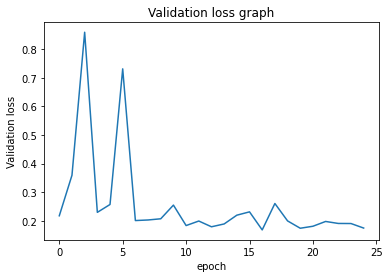

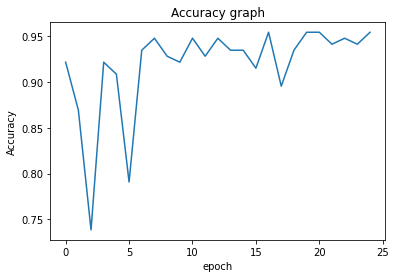

Training complete in 32m 34s
Best val Acc: 0.954248


In [ ]:
model_ft, x, vallossplot, accuracyplot = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


**OBSERVATION**

From the above graphs we can see that as the number of epochs increases, validation loss decreases and accuracy increases and attains a constant value at the end

# CHANGING NUMBER OF EPOCHS

Learning rate = 0.001

Momentum=0.9

Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3000 Acc: 0.8893
val Loss: 0.2345 Acc: 0.9150
Epoch 1/4
----------
train Loss: 0.2580 Acc: 0.8852
val Loss: 0.1725 Acc: 0.9477
Epoch 2/4
----------
train Loss: 0.2834 Acc: 0.8934
val Loss: 0.1809 Acc: 0.9542
Epoch 3/4
----------
train Loss: 0.2416 Acc: 0.9139
val Loss: 0.2508 Acc: 0.8954
Epoch 4/4
----------
train Loss: 0.2614 Acc: 0.9057
val Loss: 0.1974 Acc: 0.9281


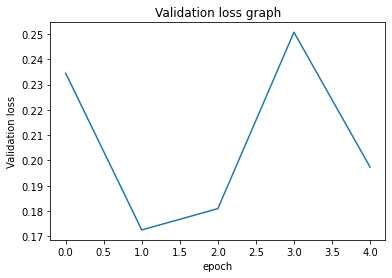

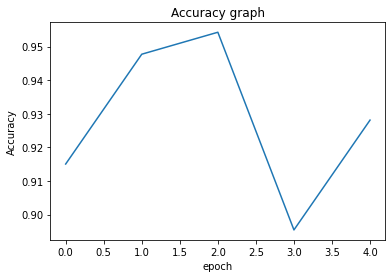

Training complete in 6m 33s
Best val Acc: 0.954248


In [ ]:
model_ft, x, vallossplot, accuracyplot = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

**OBSERVATION**

As we reduce the number of epochs to 5, we can see that there is no convergence of loss and accuracy. Hence 5 epochs are not sufficient to train the model. 

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2803 Acc: 0.8811
val Loss: 0.2027 Acc: 0.9477
Epoch 1/9
----------
train Loss: 0.2359 Acc: 0.8975
val Loss: 0.1736 Acc: 0.9542
Epoch 2/9
----------
train Loss: 0.1954 Acc: 0.9385
val Loss: 0.1919 Acc: 0.9477
Epoch 3/9
----------
train Loss: 0.3042 Acc: 0.8607
val Loss: 0.1706 Acc: 0.9477
Epoch 4/9
----------
train Loss: 0.2747 Acc: 0.8689
val Loss: 0.1768 Acc: 0.9542
Epoch 5/9
----------
train Loss: 0.2658 Acc: 0.8934
val Loss: 0.1812 Acc: 0.9542
Epoch 6/9
----------
train Loss: 0.2873 Acc: 0.8689
val Loss: 0.2120 Acc: 0.9346
Epoch 7/9
----------
train Loss: 0.2206 Acc: 0.8975
val Loss: 0.2040 Acc: 0.9281
Epoch 8/9
----------
train Loss: 0.3250 Acc: 0.8689
val Loss: 0.1992 Acc: 0.9412
Epoch 9/9
----------
train Loss: 0.2376 Acc: 0.8975
val Loss: 0.2175 Acc: 0.9216


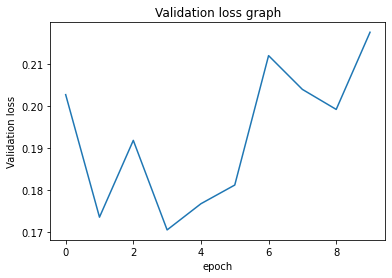

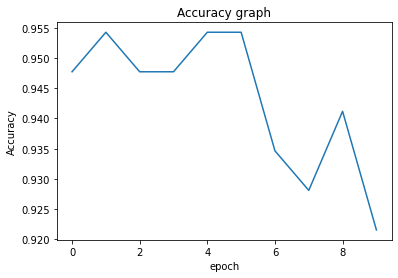

Training complete in 13m 9s
Best val Acc: 0.954248


In [ ]:
model_ft, x, vallossplot, accuracyplot = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

**OBSERVATION**

10 epochs are comparitively sufficient to train the model but still not a good choice. Accuracy and validation loss has no convergence yet  

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3388 Acc: 0.8566
val Loss: 0.1821 Acc: 0.9477
Epoch 1/14
----------
train Loss: 0.2596 Acc: 0.8730
val Loss: 0.2036 Acc: 0.9281
Epoch 2/14
----------
train Loss: 0.2879 Acc: 0.8852
val Loss: 0.2056 Acc: 0.9150
Epoch 3/14
----------
train Loss: 0.2450 Acc: 0.9221
val Loss: 0.1871 Acc: 0.9412
Epoch 4/14
----------
train Loss: 0.2631 Acc: 0.8770
val Loss: 0.1687 Acc: 0.9608
Epoch 5/14
----------
train Loss: 0.2746 Acc: 0.8730
val Loss: 0.1866 Acc: 0.9412
Epoch 6/14
----------
train Loss: 0.2177 Acc: 0.9139
val Loss: 0.2005 Acc: 0.9346
Epoch 7/14
----------
train Loss: 0.2534 Acc: 0.8566
val Loss: 0.1644 Acc: 0.9608
Epoch 8/14
----------
train Loss: 0.2473 Acc: 0.8852
val Loss: 0.1658 Acc: 0.9608
Epoch 9/14
----------
train Loss: 0.2109 Acc: 0.9262
val Loss: 0.2091 Acc: 0.9346
Epoch 10/14
----------
train Loss: 0.2533 Acc: 0.8730
val Loss: 0.1750 Acc: 0.9477
Epoch 11/14
----------
train Loss: 0.2196 Acc: 0.9221
val Loss: 0.1761 Acc: 0.9542
Epoch 12/14
----------
train Loss: 0

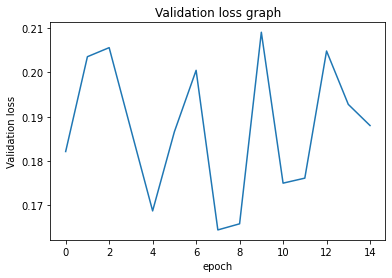

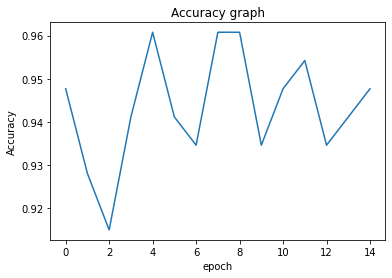

Training complete in 20m 5s
Best val Acc: 0.960784


In [ ]:
model_ft, x, vallossplot, accuracyplot = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

**OBSERVATION**
No proper convergence is found

# CHANGING LEARNING RATE 

Epoch = 10 

Momentum = 0.9

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    vallossplot = []
    accuracyplot = []
    x = list(range(0,num_epochs))
   
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:


                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
               

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

                best_model_wts = copy.deepcopy(model.state_dict())
                
        vallossplot.append(epoch_loss)
        accuracyplot.append(epoch_acc.item())
        

  
    
    plt.plot(x, vallossplot)
    plt.xlabel('epoch')
    plt.ylabel('Validation loss')
    plt.title('Validation loss graph')
    plt.show()



    plt.plot(x, accuracyplot)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy graph')
    plt.show()





            
            
            

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,x,epoch_loss,epoch_acc

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6460 Acc: 0.6393
val Loss: 0.4904 Acc: 0.7974
Epoch 1/9
----------
train Loss: 0.5280 Acc: 0.7418
val Loss: 0.3644 Acc: 0.8758
Epoch 2/9
----------
train Loss: 0.4527 Acc: 0.7951
val Loss: 0.2908 Acc: 0.9281
Epoch 3/9
----------
train Loss: 0.4386 Acc: 0.8115
val Loss: 0.2529 Acc: 0.9281
Epoch 4/9
----------
train Loss: 0.3944 Acc: 0.8484
val Loss: 0.2322 Acc: 0.9412
Epoch 5/9
----------
train Loss: 0.4759 Acc: 0.7623
val Loss: 0.2376 Acc: 0.9346
Epoch 6/9
----------
train Loss: 0.3084 Acc: 0.8852
val Loss: 0.2171 Acc: 0.9412
Epoch 7/9
----------
train Loss: 0.3791 Acc: 0.8156
val Loss: 0.2102 Acc: 0.9346
Epoch 8/9
----------
train Loss: 0.3844 Acc: 0.8320
val Loss: 0.2037 Acc: 0.9346
Epoch 9/9
----------
train Loss: 0.3466 Acc: 0.8770
val Loss: 0.2311 Acc: 0.9216


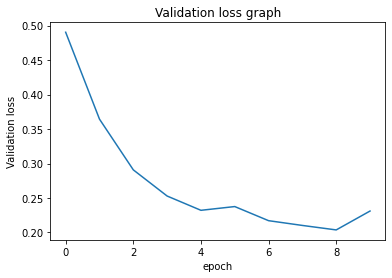

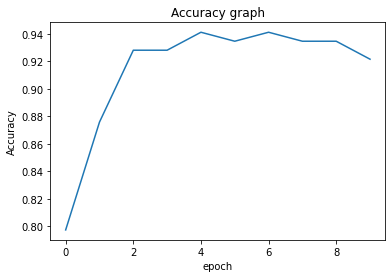

Training complete in 13m 4s
Best val Acc: 0.941176


In [ ]:
model_ft, x, vallossplot, accuracyplot = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)


**OBSERVATION**

The above considered learning rate (reduced by 10%) has given good convergence eventhough we have considered less number of epochs

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6223 Acc: 0.7295
val Loss: 0.6803 Acc: 0.8105
Epoch 1/9
----------
train Loss: 0.7481 Acc: 0.7459
val Loss: 0.8859 Acc: 0.6340
Epoch 2/9
----------
train Loss: 0.9259 Acc: 0.6680
val Loss: 1.8502 Acc: 0.6863
Epoch 3/9
----------
train Loss: 0.8973 Acc: 0.6885
val Loss: 0.7634 Acc: 0.7059
Epoch 4/9
----------
train Loss: 0.9791 Acc: 0.6885
val Loss: 0.5556 Acc: 0.7908
Epoch 5/9
----------
train Loss: 1.0344 Acc: 0.6230
val Loss: 0.5962 Acc: 0.7778
Epoch 6/9
----------
train Loss: 1.0237 Acc: 0.6148
val Loss: 1.1358 Acc: 0.5359
Epoch 7/9
----------
train Loss: 0.5460 Acc: 0.7500
val Loss: 0.4138 Acc: 0.8039
Epoch 8/9
----------
train Loss: 0.4573 Acc: 0.7951
val Loss: 0.3990 Acc: 0.8105
Epoch 9/9
----------
train Loss: 0.4594 Acc: 0.7664
val Loss: 0.3537 Acc: 0.8627


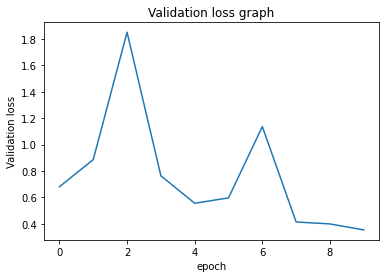

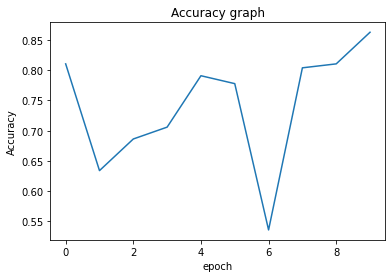

Training complete in 13m 44s
Best val Acc: 0.862745


In [ ]:
model_ft, x, vallossplot, accuracyplot = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)


**OBSERVATION**

From the above graphs we can see that increasing the actual learning rate by 0.01 has resulted in decreased convergence.

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.003, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7910 Acc: 0.6967
val Loss: 3.4958 Acc: 0.6144
Epoch 1/9
----------
train Loss: 1.4717 Acc: 0.5902
val Loss: 1.6534 Acc: 0.5359
Epoch 2/9
----------
train Loss: 1.1476 Acc: 0.5738
val Loss: 2.1097 Acc: 0.3856
Epoch 3/9
----------
train Loss: 1.3517 Acc: 0.5615
val Loss: 1.5366 Acc: 0.5752
Epoch 4/9
----------
train Loss: 1.1570 Acc: 0.5738
val Loss: 1.5317 Acc: 0.5752
Epoch 5/9
----------
train Loss: 1.4819 Acc: 0.5697
train Loss: 1.3520 Acc: 0.5820
val Loss: 1.6833 Acc: 0.6013
Epoch 7/9
----------
train Loss: 0.8180 Acc: 0.6066
val Loss: 0.6485 Acc: 0.6863
Epoch 8/9
----------
train Loss: 0.5725 Acc: 0.7172
val Loss: 0.6026 Acc: 0.6993
Epoch 9/9
----------
train Loss: 0.5786 Acc: 0.7295
val Loss: 0.5576 Acc: 0.7255


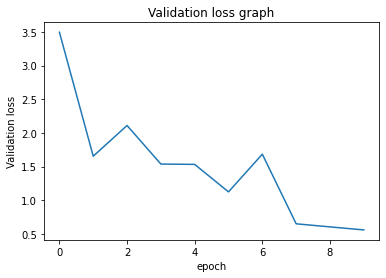

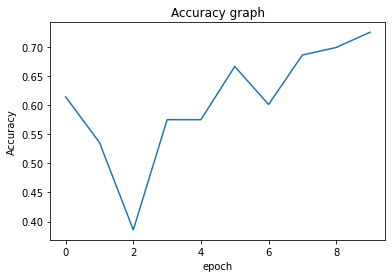

Training complete in 13m 34s
Best val Acc: 0.725490


In [ ]:
model_ft, x, vallossplot, accuracyplot = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)


**OBSERVATION**

We can see that comparitively the convergence is less, but the solution has convergeg for less number of epochs also.

# CHANGE IN MOMENTUM

Learning rate = 0.01

Epoch = 10

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    vallossplot = []
    accuracyplot = []
    x = list(range(0,num_epochs))
   
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                     

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

                best_model_wts = copy.deepcopy(model.state_dict())
                
        vallossplot.append(epoch_loss)
        accuracyplot.append(epoch_acc.item())
        

  
    
    plt.plot(x, vallossplot)
    plt.xlabel('epoch')
    plt.ylabel('Validation loss')
    plt.title('Validation loss graph')
    plt.show()



    plt.plot(x, accuracyplot)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy graph')
    plt.show()
           

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,x,epoch_loss,epoch_acc

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.7)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5811 Acc: 0.6967
val Loss: 0.2448 Acc: 0.9216
Epoch 1/9
----------
train Loss: 0.4331 Acc: 0.7992
val Loss: 0.2070 Acc: 0.9477
Epoch 2/9
----------
train Loss: 0.4333 Acc: 0.7910
val Loss: 0.1939 Acc: 0.9216
Epoch 3/9
----------
train Loss: 0.3924 Acc: 0.8238
val Loss: 0.1885 Acc: 0.9412
Epoch 4/9
----------
train Loss: 0.3585 Acc: 0.8402
val Loss: 0.1582 Acc: 0.9542
Epoch 5/9
----------
train Loss: 0.3842 Acc: 0.7828
val Loss: 0.1545 Acc: 0.9608
Epoch 6/9
----------
train Loss: 0.3981 Acc: 0.7828
val Loss: 0.3314 Acc: 0.8562
Epoch 7/9
----------
train Loss: 0.4504 Acc: 0.7746
val Loss: 0.1925 Acc: 0.9281
Epoch 8/9
----------
train Loss: 0.3132 Acc: 0.8484
val Loss: 0.1852 Acc: 0.9477
Epoch 9/9
----------
train Loss: 0.3012 Acc: 0.8730
val Loss: 0.1954 Acc: 0.9020


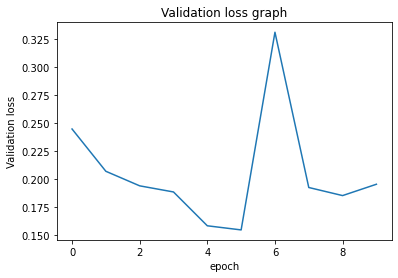

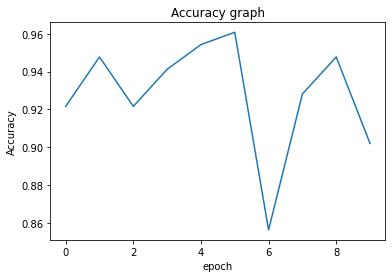

Training complete in 12m 56s
Best val Acc: 0.960784


In [ ]:
model_ft, x, vallossplot, accuracyplot = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)


**OBSERVATION**

Reducing the momentum to 0.7 was not a good idea. It has decreased accuracy

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.99)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.9197 Acc: 0.6680
val Loss: 3.0573 Acc: 0.5752
Epoch 1/9
----------
train Loss: 2.6065 Acc: 0.4877
val Loss: 6.6179 Acc: 0.5425
Epoch 2/9
----------
train Loss: 1.9699 Acc: 0.5615
val Loss: 36.4367 Acc: 0.5621
Epoch 3/9
----------
train Loss: 2.0060 Acc: 0.5738
val Loss: 2.9255 Acc: 0.5556
Epoch 4/9
----------
train Loss: 2.0062 Acc: 0.5205
val Loss: 2.6358 Acc: 0.5882
Epoch 5/9
----------
train Loss: 2.3863 Acc: 0.4836
val Loss: 4.6710 Acc: 0.5425
Epoch 6/9
----------
train Loss: 2.1359 Acc: 0.4918
val Loss: 1.6712 Acc: 0.5621
Epoch 7/9
----------
train Loss: 1.4128 Acc: 0.5492
val Loss: 1.5651 Acc: 0.5425
Epoch 8/9
----------
val Loss: 1.0166 Acc: 0.5621
Epoch 9/9
----------
train Loss: 0.7353 Acc: 0.6270
val Loss: 0.7941 Acc: 0.5948


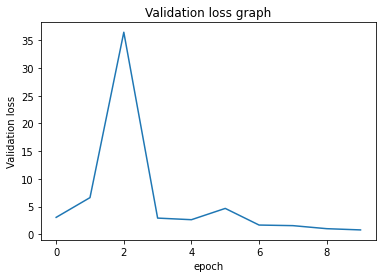

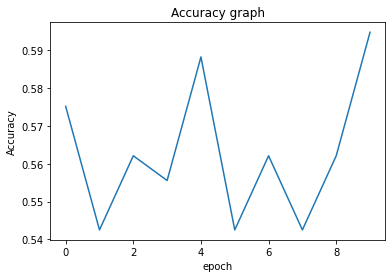

Training complete in 13m 26s
Best val Acc: 0.594771


In [ ]:
model_ft, x, vallossplot, accuracyplot = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)


**OBSERVATION**

Increasing the momentum from 0.9 to 0.99 has resulted in increased validtion loss and a huge reduction in accuracy. Both of these are not good features. Hence an increment in momentum is not preferable

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.8)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4892 Acc: 0.7746
val Loss: 0.2222 Acc: 0.9542
Epoch 1/9
----------
train Loss: 0.3772 Acc: 0.8115
val Loss: 0.2907 Acc: 0.8497
Epoch 2/9
----------
train Loss: 0.4419 Acc: 0.8238
val Loss: 0.1977 Acc: 0.9477
Epoch 3/9
----------
train Loss: 0.3469 Acc: 0.8279
val Loss: 0.2005 Acc: 0.9412
Epoch 4/9
----------
train Loss: 0.3209 Acc: 0.8648
val Loss: 0.1546 Acc: 0.9477
Epoch 5/9
----------
train Loss: 0.3675 Acc: 0.8279
val Loss: 0.2233 Acc: 0.9150
Epoch 6/9
----------
train Loss: 0.3176 Acc: 0.8648
val Loss: 0.1324 Acc: 0.9542
Epoch 7/9
----------
train Loss: 0.2823 Acc: 0.8934
val Loss: 0.1346 Acc: 0.9346
Epoch 8/9
----------
train Loss: 0.3139 Acc: 0.8566
train Loss: 0.3240 Acc: 0.8607
val Loss: 0.1390 Acc: 0.9412


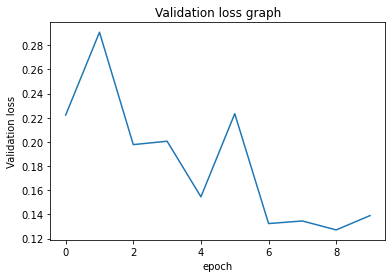

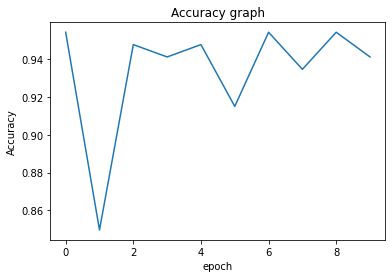

Training complete in 12m 40s
Best val Acc: 0.954248


In [ ]:
model_ft, x, vallossplot, accuracyplot = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)


**OBSERVATION**

Here the decrease of momentum from 0.9 to 0.8 has resulted in increased accuracy and decreased validation loss, both of which are acceptable. 

# REFERENCES USED

1. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

2. https://pytorch.org/docs/stable/optim.html